# Filter Zero Outter Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from experiments.multi_experiment import MultiExperiment
from experiments.reversed_single_filter.experiment import ReversedSingleFilterExperiment
from functools import reduce
from parse import parse

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def create_df(experiment: ReversedSingleFilterExperiment) -> pd.DataFrame:
    fmt = "{layer_name}_{i}_{j}_{row}_{col}"
    result = parse(fmt, experiment.get_name(depth=1))
    for stats in experiment.get_train_statistics():
        csv = pd.read_csv(stats)
        csv["grid"] = f'{result["row"]},{result["col"]}'
        yield csv
    

relevant_columns = ["error", "energy", "area", "delay", "gate_count"]
fitness_columns = ["error", "quantized_energy", "area", "quantized_delay", "gate_count"]
quantized_columns = ["error", "quantized_energy", "quantized_delay"]
# experiment = Experiment.with_data_only("../../data_store/zero_outter/conv1_0_0")
multi_experiment = MultiExperiment.with_data_only("../../data_store/reversed_single_filter")
df = pd.concat([df for experiment in multi_experiment.get_experiments() for df in create_df(experiment)], ignore_index=True)
df.drop(columns="depth", inplace=True, errors="ignore")
df.drop_duplicates(subset=["generation"], inplace=True)
df


warn: [Errno 2] No such file or directory: '..\\..\\data_store\\reversed_single_filter\\reversed_single_filter.tar\\train_cgp.config'


,run,generation,timestamp,error,quantized_energy,energy,area,quantized_delay,delay,gate_count,chromosome,grid
0,1,1,0.000095,25475,2.543004e+17,0.208919,787.485394,2.350065e+18,0.93,27,NaN,"10,10"
1,1,2,0.000272,12731,2.268378e+17,0.186357,731.169391,1.844674e+18,0.73,30,NaN,"10,10"
2,1,3,0.000456,7723,4.073705e+17,0.334673,1059.210091,2.678568e+18,1.06,30,NaN,"10,10"
3,1,4,0.004245,5718,2.286335e+17,0.187832,703.949993,2.678568e+18,1.06,28,NaN,"10,10"
4,1,5,0.004419,5606,2.287690e+17,0.187944,712.866692,2.678568e+18,1.06,26,NaN,"10,10"
...,...,...,...,...,...,...,...,...,...,...,...,...
82389,9,44899,3.095552,0,7.538491e+17,0.154830,448.181496,3.689349e+18,0.73,9,"{16,9,5,5,2,5,5}([16]8,5,15)([17]7,7,0)([18]10...","5,5"
82390,9,100632,6.989711,0,7.538491e+17,0.154830,448.181496,1.768866e+18,0.35,10,"{16,9,5,5,2,5,5}([16]8,5,15)([17]7,7,0)([18]10...","5,5"
82391,9,126756,8.796657,0,1.372599e+17,0.028191,152.522500,3.285037e+18,0.65,9,"{16,9,5,5,2,5,5}([16]8,5,15)([17]7,7,0)([18]9,...","5,5"
82392,9,139256,9.657722,0,1.597936e+16,0.003282,71.802898,1.768866e+18,0.35,10,"{16,9,5,5,2,5,5}([16]8,5,15)([17]7,7,0)([18]9,...","5,5"


## Data Exploration Analysis

In [83]:
df.describe()

,run,generation,timestamp,error,quantized_energy,energy,area,quantized_delay,delay,gate_count
count,932.000000,9.320000e+02,932.000000,932.000000,9.320000e+02,932.000000,932.000000,9.320000e+02,932.000000,932.00000
mean,14.847639,1.118718e+05,15.950583,93.733906,2.707661e+17,0.055612,263.320098,2.536387e+18,0.501867,11.47103
std,8.823387,3.423469e+05,49.261674,455.523992,4.093954e+17,0.084084,227.609479,1.768305e+18,0.349889,1.82070
min,1.000000,1.000000e+00,0.000195,0.000000,2.088800e+13,0.000004,9.855300,0.000000e+00,0.000000,7.00000
25%,7.000000,3.890000e+02,0.060400,0.000000,1.613087e+16,0.003313,92.452097,1.415093e+18,0.280000,10.00000
50%,14.000000,3.818500e+03,0.540635,0.000000,1.120966e+17,0.023024,195.228798,3.108150e+18,0.615000,11.00000
75%,23.000000,2.387575e+04,3.247126,12.000000,2.738917e+17,0.056254,365.819350,3.436654e+18,0.680000,13.00000
max,30.000000,2.890469e+06,427.003090,7968.000000,2.350754e+18,0.482812,1283.066194,8.945407e+18,1.770000,19.00000


In [11]:
generation_df = df.copy()

runs = generation_df["run"].unique()
grids = generation_df["grid"].unique()
new_dfs = []
for grid in grids:
    for run in runs:
        run_df = generation_df.loc[(generation_df["run"] == run) & (generation_df["grid"] == grid), :]
        run_df["generation_delta"] = run_df["generation"].diff()
        
        for col in fitness_columns:
            if col != "area":
                run_df[f"{col}_delta"] = run_df[col].diff()
            else:
                run_df[f"{col}_delta"] = run_df[col]
        run_df = run_df.iloc[1:]
        for col in fitness_columns:
            run_df[f"{col}_delta"] = run_df[f"{col}_delta"].apply(lambda x: x if x < 0 else 0)

        zero_deltas = [run_df[f"{col}_delta"] == 0 for col in fitness_columns]
        run_df = run_df.loc[~reduce(lambda a, b: a & b, zero_deltas), :]
        run_df["run"] = run
        new_dfs.append(run_df)


dfs_delta = pd.concat(new_dfs)
epoch = 100000
for gen in range(0, dfs_delta["generation"].max() + epoch, epoch):
    dfs_delta.loc[dfs_delta["generation"].isin(range(gen, gen+epoch)), "generation"] = gen

dfs_delta.iloc[dfs_delta["generation_delta"].idxmax()]

C:\Users\Majo\AppData\Local\Temp\ipykernel_25932\2272395637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df["generation_delta"] = run_df["generation"].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_25932\2272395637.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df[f"{col}_delta"] = run_df[col].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_25932\2272395637.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

run                                                                      23
generation                                                                0
timestamp                                                          4.105609
error                                                                     0
quantized_energy                                         8075481307530785.0
energy                                                             0.006634
area                                                             148.768095
quantized_delay                                        985510984759825408.0
delay                                                                  0.39
gate_count                                                               12
chromosome                {16,9,10,10,2,10,5}([16]1,4,7)([17]5,0,23)([18...
grid                                                                  10,10
generation_delta                                                     7040.0
error_delta 

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

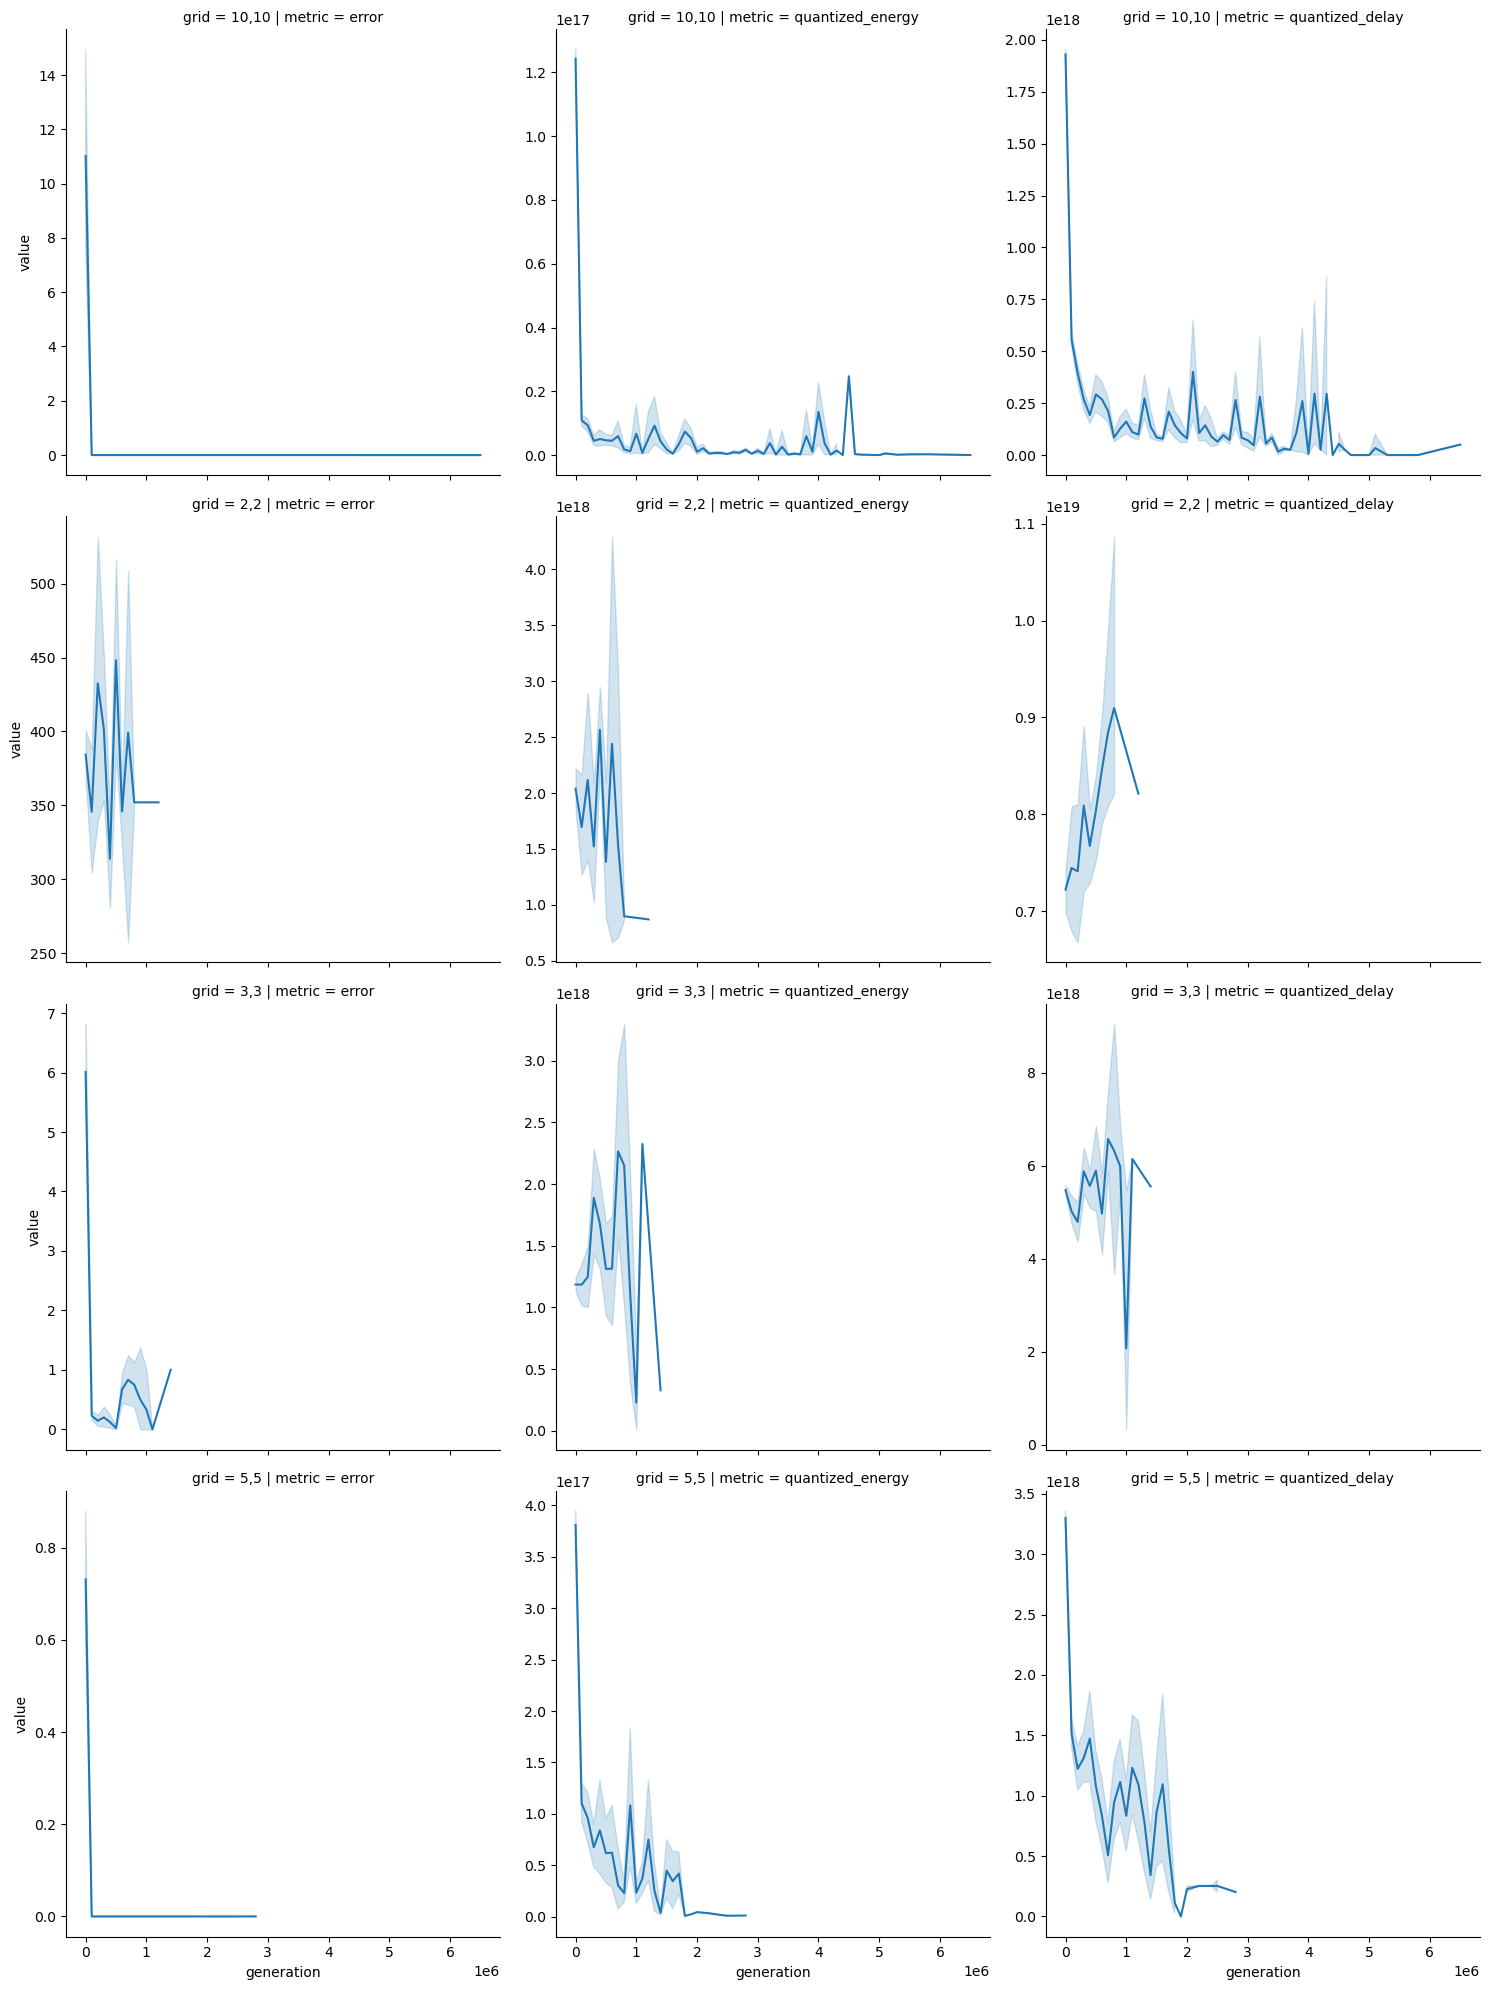

In [22]:
plot_df = pd.melt(dfs_delta, id_vars=["generation", "grid"], value_vars=quantized_columns, var_name="metric")

sns.relplot(data=plot_df, x="generation", y="value", row="grid", col="metric", kind="line", facet_kws={"sharey": False, "sharex": True})

## Data Preparation

In [86]:
clean_df = df.copy()

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (clean_df["run"] == run) & (clean_df["generation"].isna())
    clean_df.loc[condition, relevant_columns] = clean_df.loc[condition, relevant_columns].min()

# clean_df.loc[clean_df["error"].isna(), :].tail(20)
clean_df

,run,generation,timestamp,error,quantized_energy,energy,area,quantized_delay,delay,gate_count,chromosome
0,1,1,0.000195,7968,739794977816172310,0.151943,464.137694,3689348814741910322,0.73,14,NaN
1,1,2,0.016073,3148,738786884943426140,0.151736,426.593696,3689348814741910322,0.73,13,NaN
2,1,3,0.016327,3127,754546491462227596,0.154973,484.786894,3689348814741910322,0.73,13,NaN
3,1,4,0.016594,3058,754519635326288132,0.154968,472.115794,3689348814741910322,0.73,12,NaN
4,1,7,0.017501,2974,754519635326288132,0.154968,472.115794,3689348814741910322,0.73,12,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52,9,18479,2.457512,0,27773209878615829,0.005704,111.224096,1667787820362781378,0.33,9,"{16,9,5,5,2,5,5}([16]15,0,13)([17]15,7,21)([18..."
53,9,26391,3.609404,0,27328076949063523,0.005613,92.452097,1667787820362781378,0.33,10,"{16,9,5,5,2,5,5}([16]15,0,13)([17]15,7,21)([18..."
54,9,46889,6.328746,0,13704937107366021,0.002815,71.802898,1667787820362781378,0.33,10,"{16,9,5,5,2,5,5}([16]15,0,13)([17]15,7,21)([18..."
55,9,73639,9.925640,0,4272933354207908,0.000878,75.087998,202156099437912894,0.04,10,"{16,9,5,5,2,5,5}([16]15,0,13)([17]15,7,21)([18..."


## Learning Rate

In [87]:
learn_df = pd.concat([pd.read_csv(x) for x in experiment.get_learn_rate_statistics(runs=1)])
learn_df

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data_store\\reversed_single_filter\\conv2_0_0_5_5\\train_statistics\\learning\\learning_rate.1.csv'

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


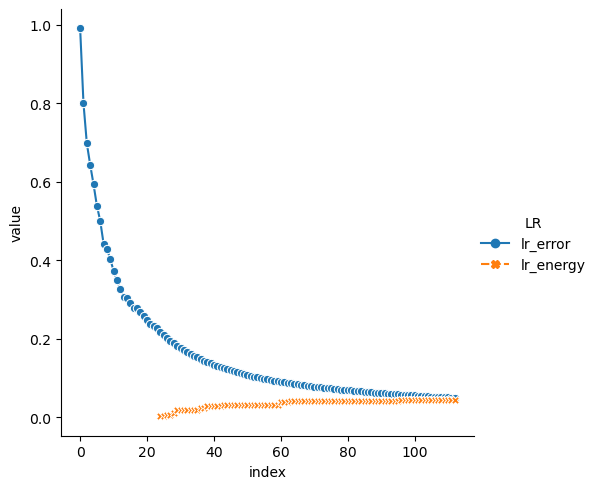

In [ ]:
table_df = pd.melt(learn_df.reset_index(inplace=False), id_vars=["index"], value_vars=["lr_error", "lr_energy"], var_name="LR")
# table_df = table_df.loc[table_df["index"].isin(range(60, 71))]
# Filter the dataframe for the first set of data (lr_error)
a = table_df.loc[table_df["LR"] == "lr_error"]
b = table_df.loc[table_df["LR"] == "lr_energy"]
# a.loc[table_df["value"] == 0, "value"] = a["value"].max()
# b.loc[table_df["value"] == 0, "value"] = b["value"].max()
table_df.loc[(table_df["value"] == 0) & (table_df["LR"] == "lr_error"), "value"] = a.loc[table_df["LR"] == "lr_error", "value"].max()
table_df.loc[(table_df["value"] == 0) & (table_df["LR"] == "lr_energy"), "value"] = a.loc[table_df["LR"] == "lr_energy", "value"].max()

# Plot the first set of data
ax = sns.relplot(data=table_df, x="index", y="value", hue="LR", style="LR", markers=True, kind="line")
# ax2 = plt.twinx()
# ax = sns.lineplot(data=b, x="index", y="value", color="orange", style="LR", markers=True, ax=ax2)


## Evolution Progress

C:\Users\Majo\AppData\Local\Temp\ipykernel_20136\2664694428.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-pa

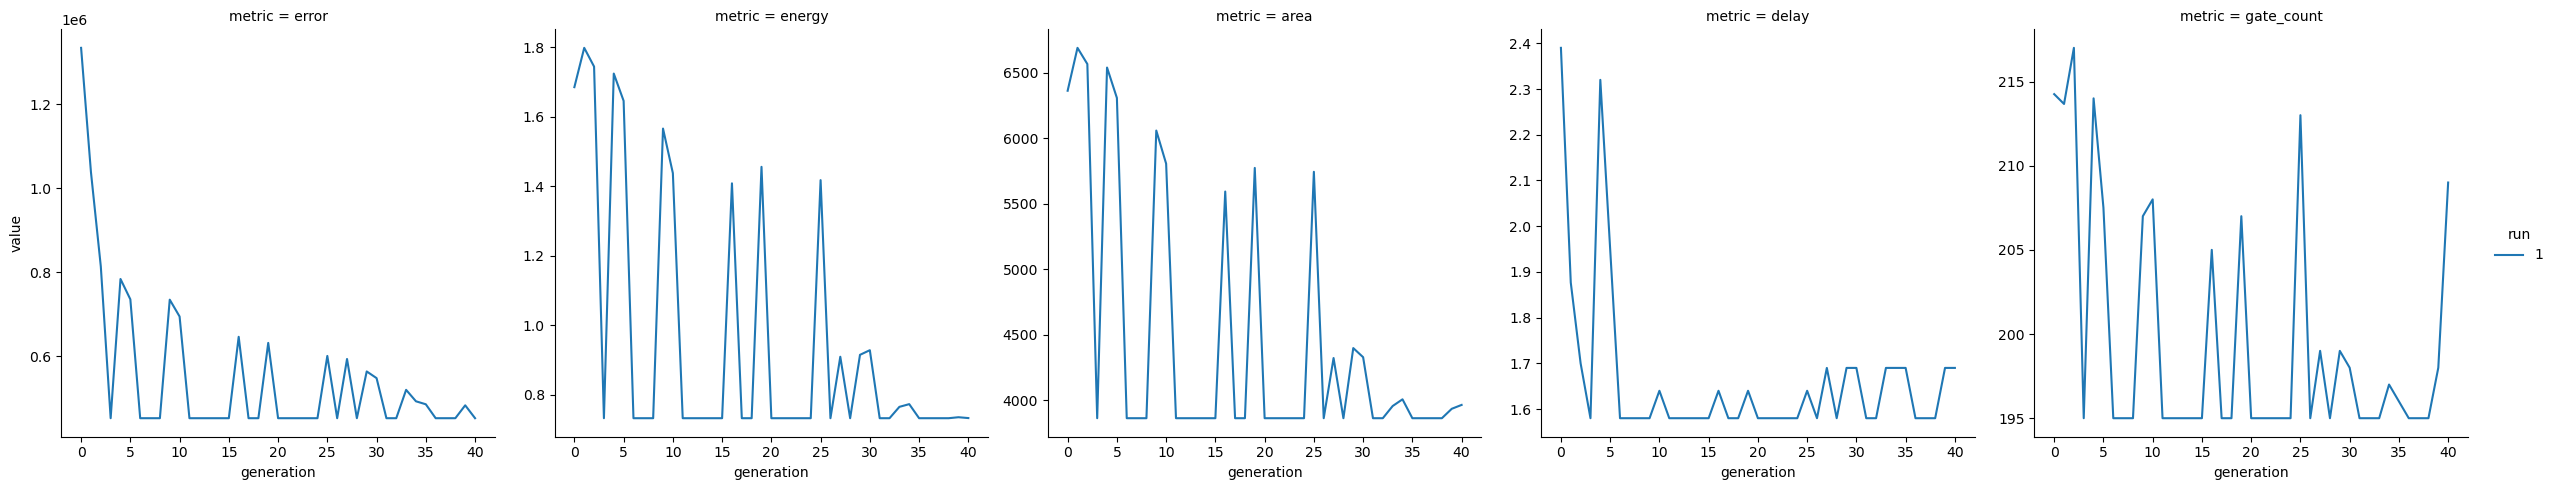

''

In [ ]:
generation_group = 10
bin_quantity = 50
# Create a 2x3 subplot layout
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

filtered_df = clean_df.loc[clean_df["generation"] <= (generation_group * bin_quantity), :]

bins = np.arange(0, filtered_df["generation"].max() + generation_group, generation_group)
quantizer = pd.cut(filtered_df["generation"], bins=bins)
quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
quantized_df.reset_index(inplace=True)

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (quantized_df["run"] == run) & (quantized_df["error"].isna())
    for col in relevant_columns:
        quantized_df.loc[condition, col] = quantized_df.loc[quantized_df["run"] == run, col].min(skipna=True)


quantized_df = pd.melt(quantized_df, id_vars=["run", "generation"], value_vars=relevant_columns, var_name="metric", value_name="value")
quantized_df["generation"] = quantized_df["generation"].cat.codes
quantized_df = quantized_df.loc[quantized_df["generation"] < 50, :]
sns.relplot(data=quantized_df, x="generation", y="value", hue="run", col="metric", kind="line", facet_kws={"sharey": False})
plt.show()
;

,run,generation,timestamp,error,energy,area,delay,gate_count,chromosome
0,1,1,0.001519,1366186,1.583041,6041.768147,2.39,208,NaN
1,1,4,0.001879,1331970,1.733477,6519.984843,2.39,217,NaN
2,1,5,0.002055,1326799,1.713366,6455.690740,2.39,215,NaN
3,1,6,0.002234,1311941,1.713038,6427.063440,2.39,217,NaN
4,1,13,0.002933,1279509,1.861904,6801.564838,2.39,217,NaN
...,...,...,...,...,...,...,...,...,...
834,1,14636139,968.967559,50,0.743364,2714.431180,0.74,95,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
835,1,14840671,986.479433,50,0.743364,2714.431180,0.74,94,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
836,1,16274404,1084.227558,50,0.743364,2714.431180,0.74,93,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
837,1,16496758,1098.931182,50,0.743249,2695.659181,0.74,92,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."


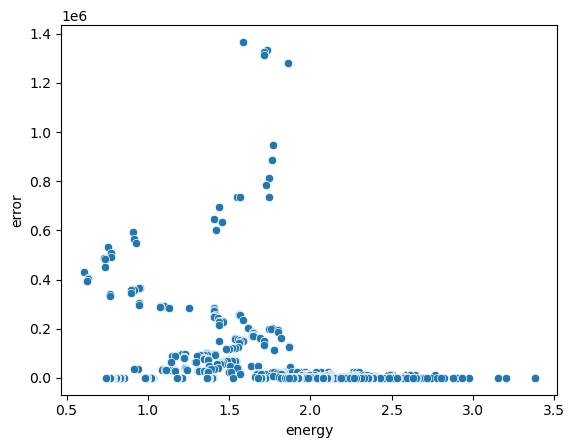

In [ ]:
sns.scatterplot(data=clean_df.loc[clean_df["error"].notna() & clean_df["energy"].notna()], x="energy", y="error")
# plt.show()
clean_df